## Step 3:
Loading up the data from a specific cellpose run

In [6]:
dat = np.load(save_path + '10061218_height_seg.npy', allow_pickle=True).item()

In [7]:
#!!### I think this will actually be useful for the metadata. 
perimiters = utils.get_mask_perimeters(dat['masks'])

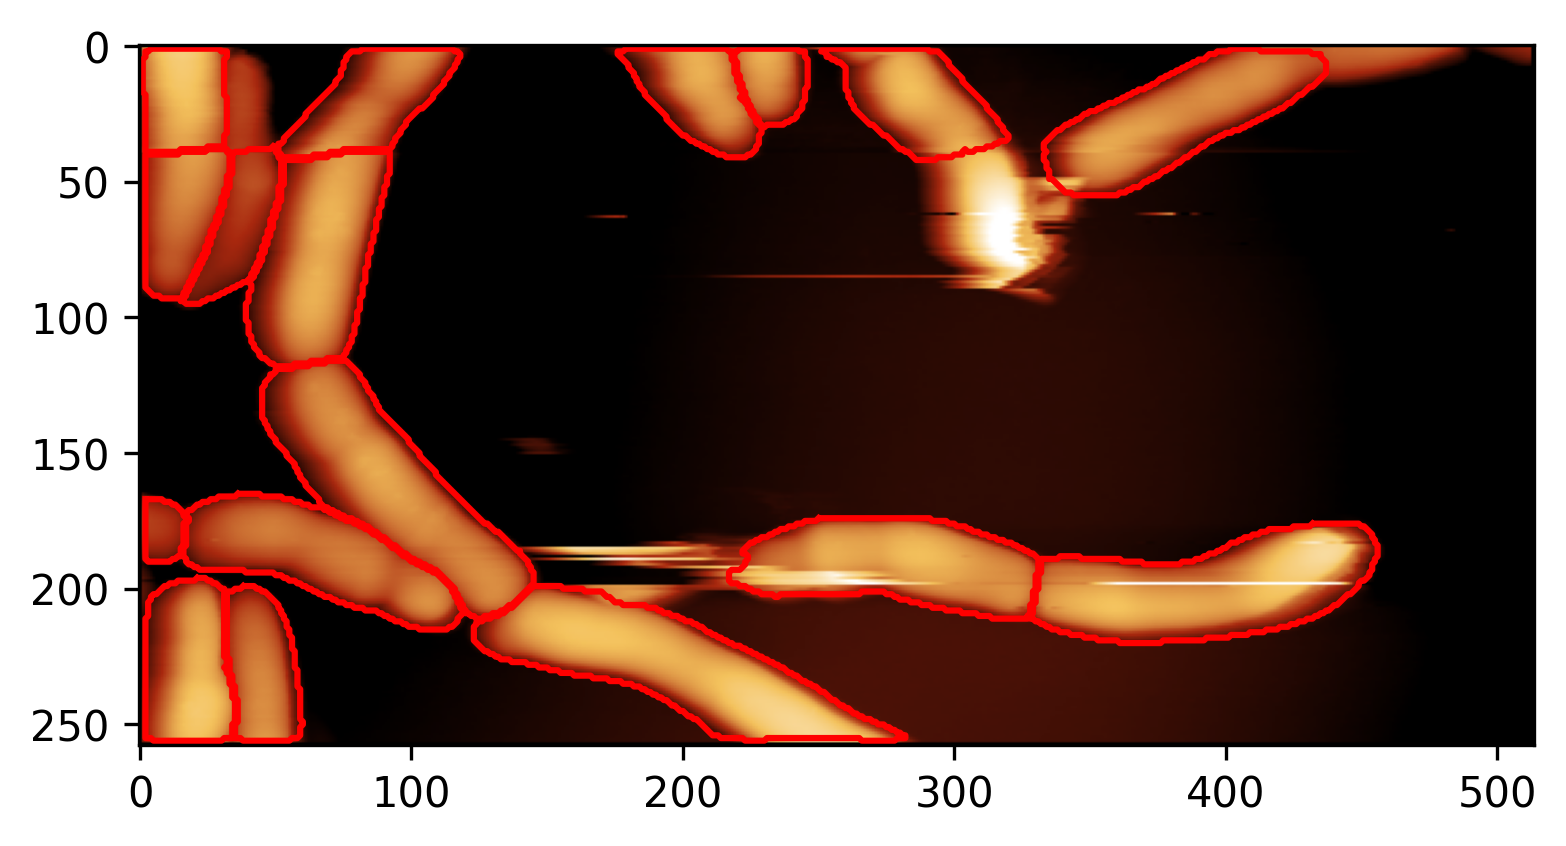

In [9]:
# plot image with outlines overlaid in red
outl = utils.outlines_list(dat['masks'])
plt.imshow(dat['img'])
for o in outl:
    plt.plot(o[:,0], o[:,1], color='r')

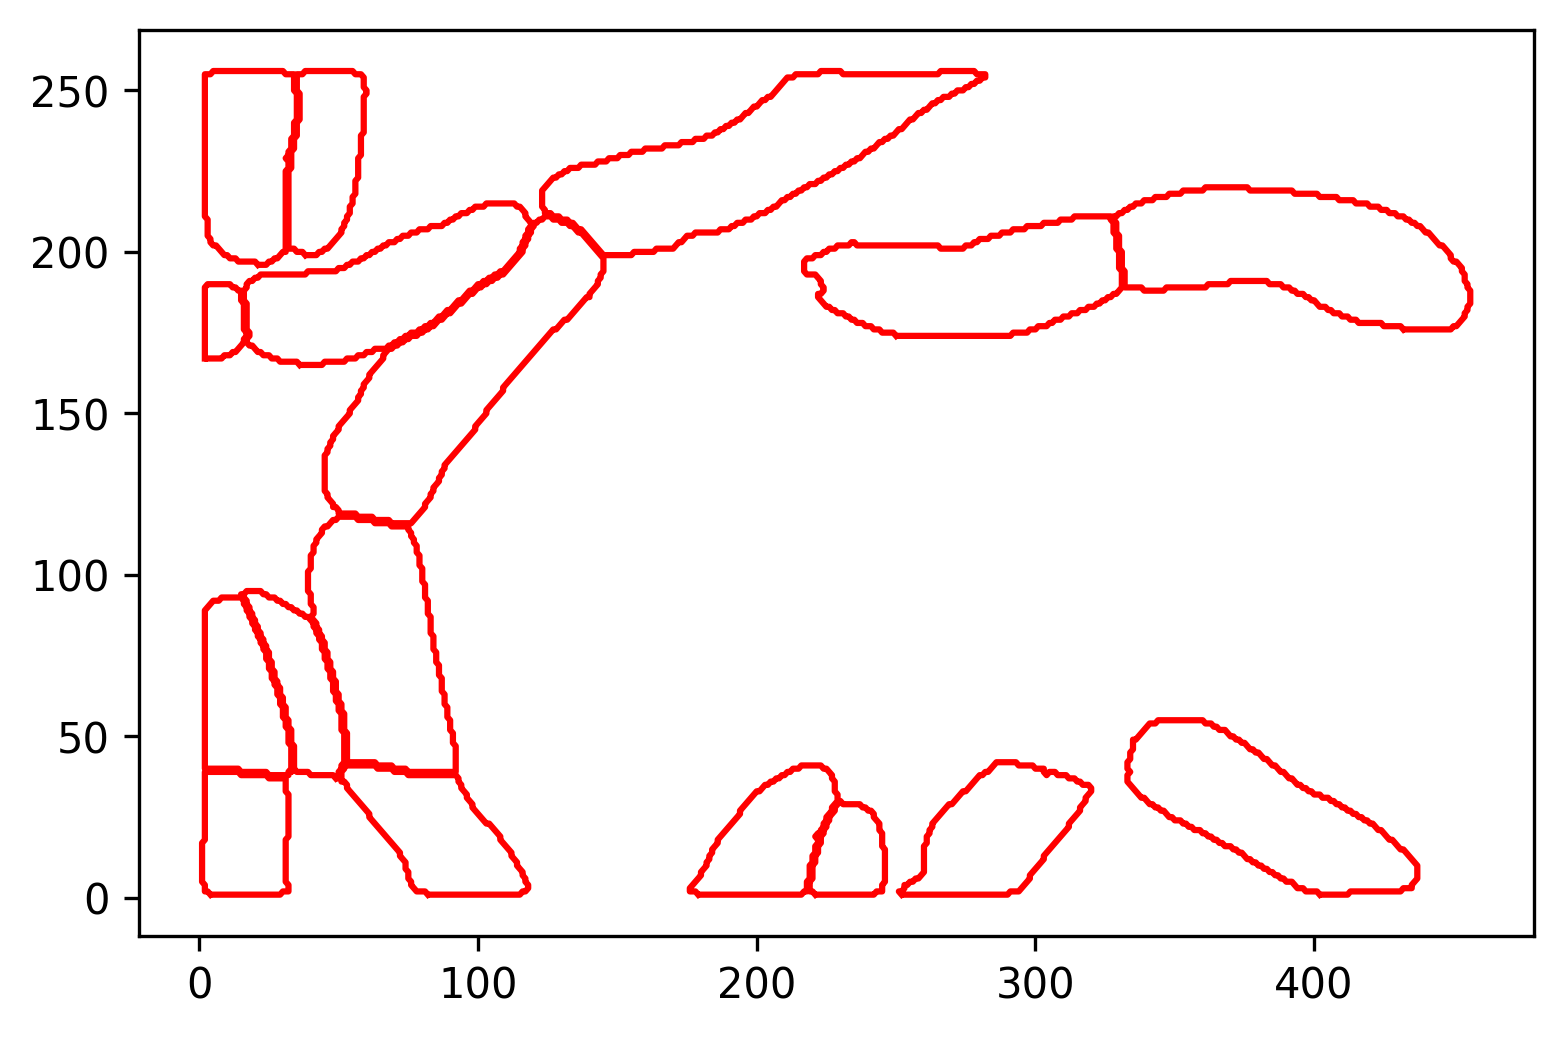

In [10]:
#plot just the outlines. 
for o in outl:
    plt.plot(o[:,0], o[:,1], color='r')

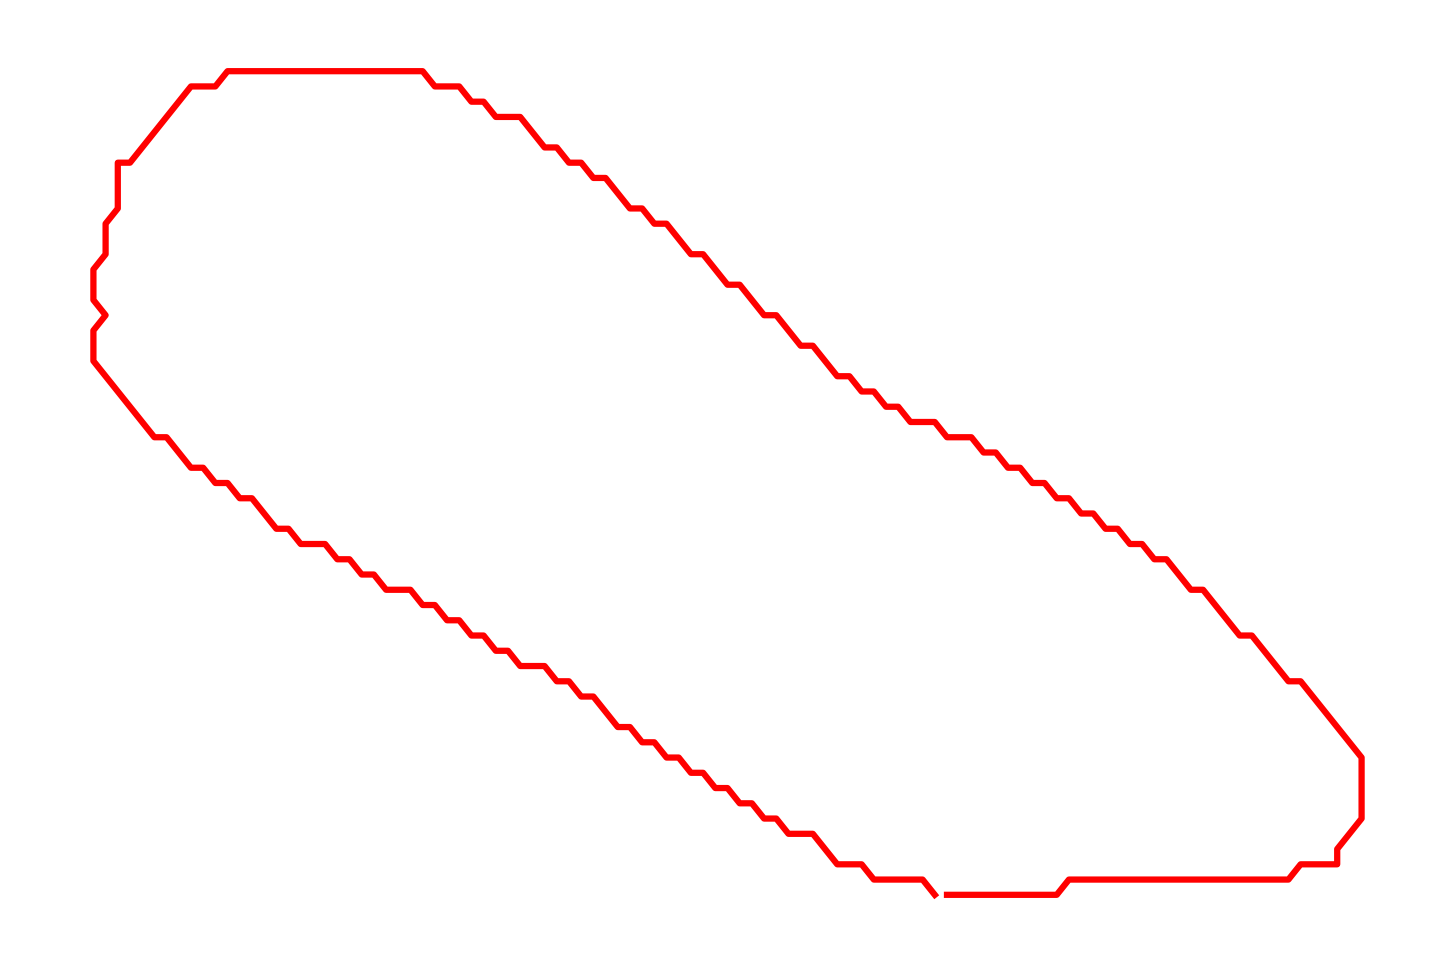

In [13]:
# plot an individual cell of choice. 
plt.plot(outl[5][:,0], outl[5][:,1], color = "r")
plt.axis("off")
plt.savefig("test.png")

In [14]:
dat.keys()

dict_keys(['img', 'outlines', 'masks', 'chan_choose', 'ismanual', 'filename', 'flows', 'est_diam'])

In [16]:
import cv2

masks = dat["masks"]

img = dat["img"]
ls_outlines = utils.outlines_list(masks)

for idx, cell in enumerate(ls_outlines[:]):
    # mask outline
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    cv2.fillPoly(mask, [cell], ignore_mask_color)
    
    # crop the cell
    x = cell.flatten()[::2]
    y = cell.flatten()[1::2]

    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = mask[topy:bottomy+1, topx:bottomx+1]
    
    #cv2.imwrite(os.path.join(name, str(idx) + ".png" ), out)
    im = Image.fromarray(out)
    im.save("AFM_Automation_code/Individual_masks/" + str(idx) + ".png")

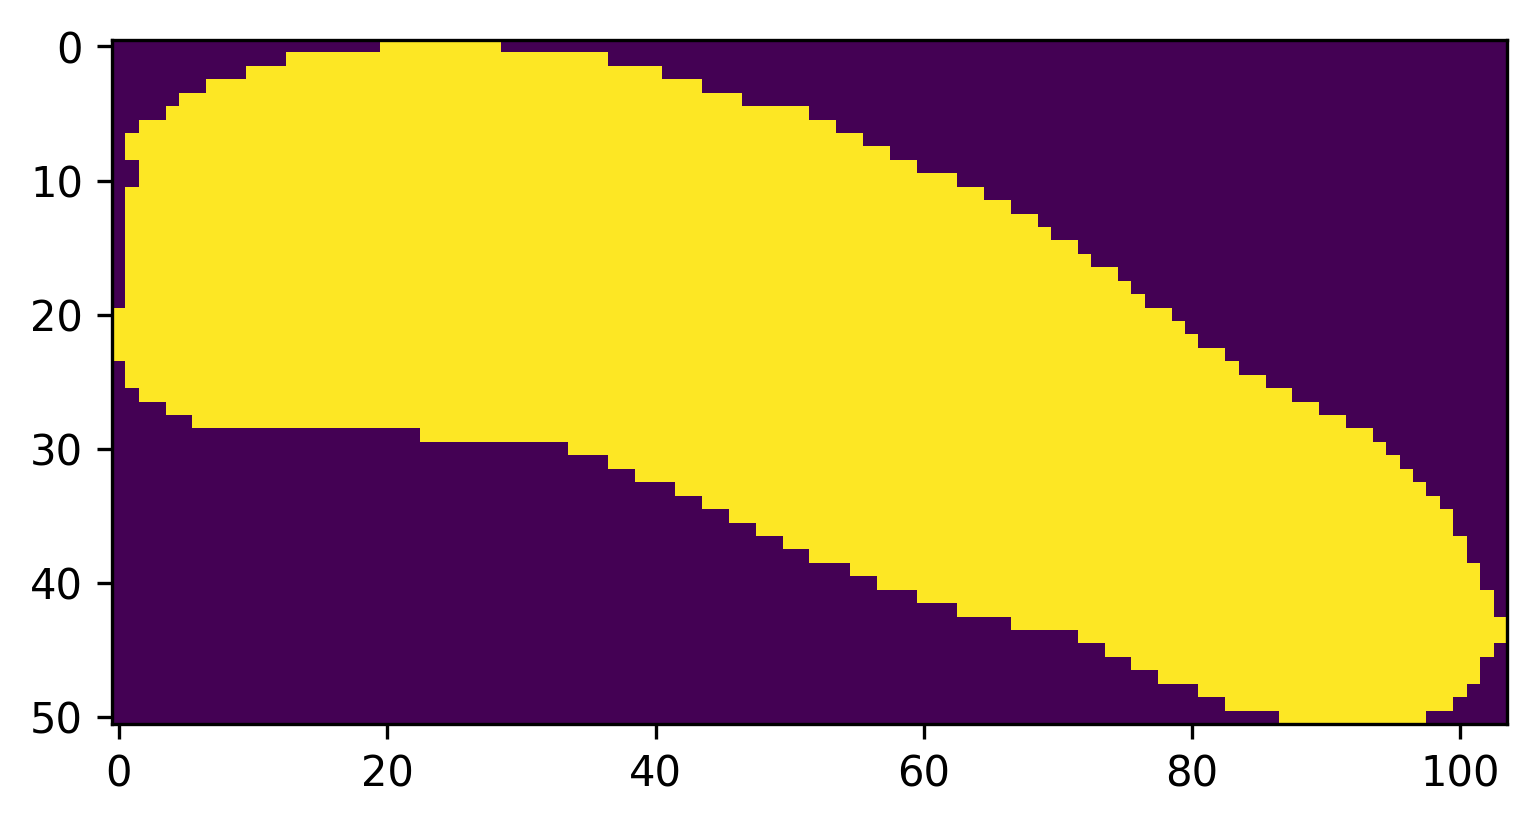

In [17]:
cell = ls_outlines[10]
img = dat["img"]
# mask outline
mask = np.zeros(img.shape[0:2], dtype=np.uint8)
cv2.fillPoly(mask, [cell], color = (255,255,255))

#masked_image = cv2.bitwise_and(img, mask2)
    
# crop the cell
x = cell.flatten()[::2]
y = cell.flatten()[1::2]

(topy, topx) = (np.min(y), np.min(x))
(bottomy, bottomx) = (np.max(y), np.max(x))
out = mask[topy:bottomy+1, topx:bottomx+1]

plt.imshow(out)

# Finding the centers

In [18]:
import imutils

In [19]:
dat = np.load(save_path + '10061218_height_seg.npy', allow_pickle=True).item()
img = dat["img"]

thresholds = []

for idx, cell in enumerate(ls_outlines[:]):
    # mask outline
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    thresh = cv2.fillPoly(mask, [cell], ignore_mask_color)
    thresholds.append(thresh)

In [20]:
cnts_list = []
for thresh in thresholds:
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts_list.append(cnts)

### notes
Ok, this clearly works well, I just need to alter it so that it works with my images in particular rather than having a total mental breakdown. 

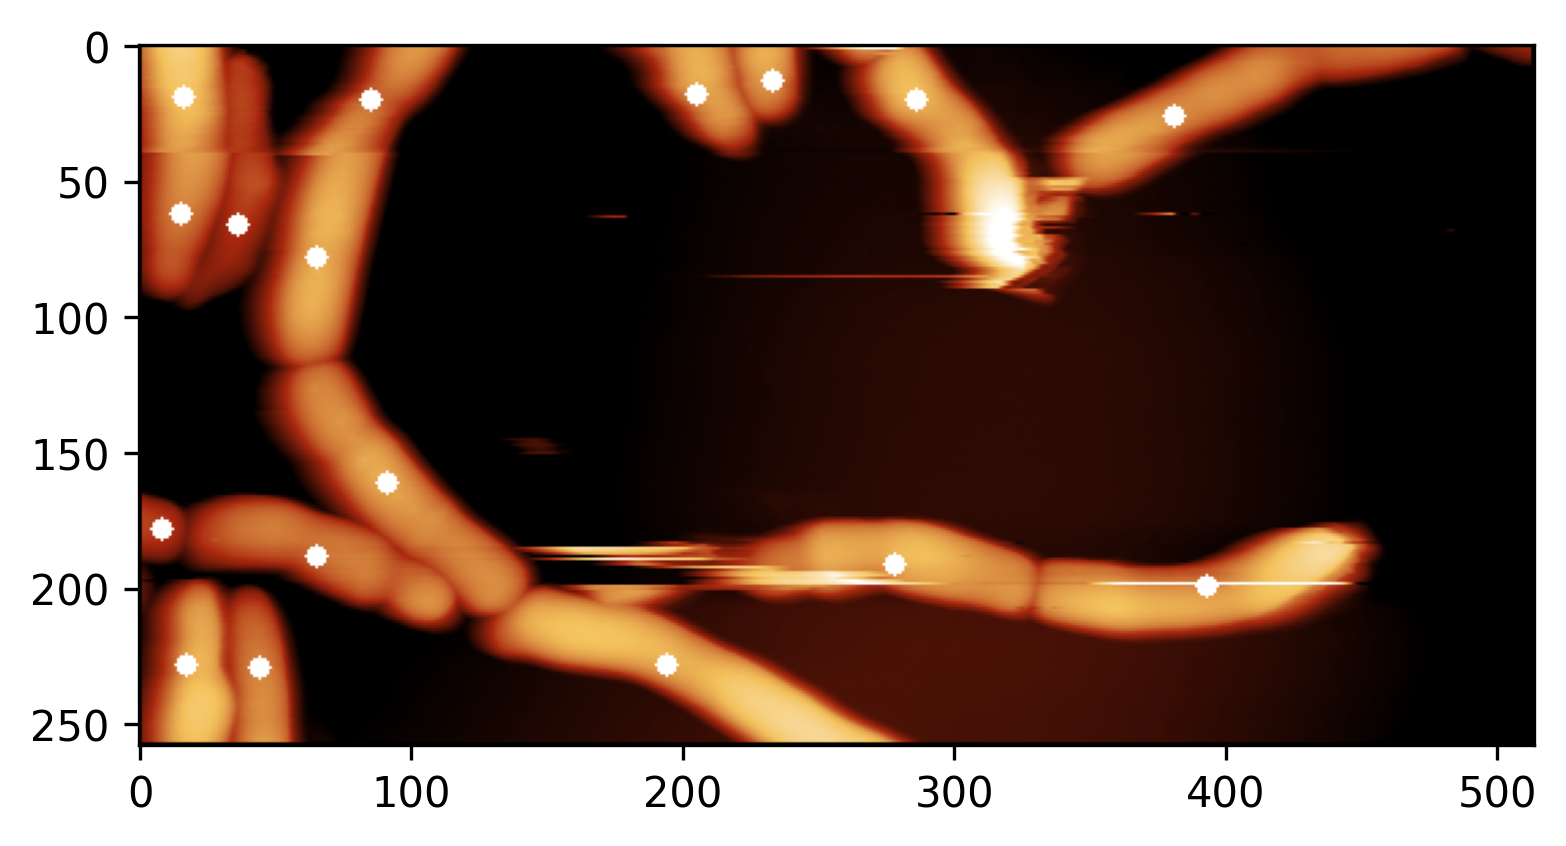

In [21]:
# loop over the contours
for cnts in cnts_list:
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        # draw the contour and center of the shape on the image
        cv2.circle(img, (cX, cY), 4, (255, 255, 255), -1)
        # show the image
plt.imshow(img)
# Alright, so these cX and cYs contain all of the information I need on the center of the images. 

useful utils may include:
- fill_holes_and_remove_small_masks
- get_mask_compactness
- get_mask_stats
- distance_to_boundary. This determines the distance of each pixel in a mask to the boundaries (I think). If I find the max of this it might help me find a center, although the rod shape may screw with that. 
- radius distribution 
- metrics 
- remove_edge_masks. This removes any mask that has a pixel on the edge of the image, might be helpful when cleaning up images. Would have to be careful not to screw with the metadata. Hmm, this does not work so good

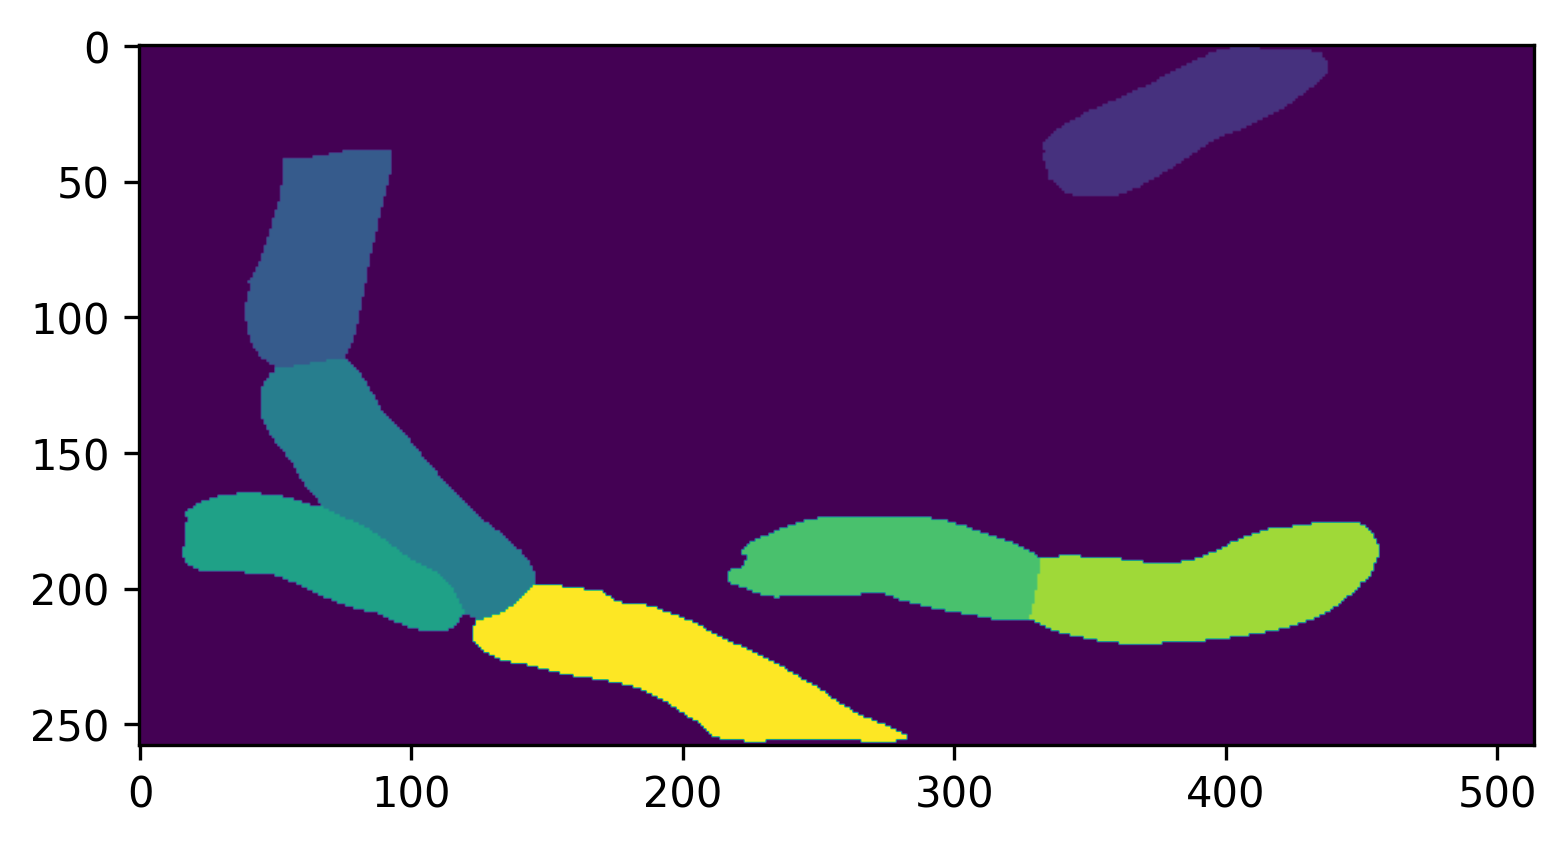

In [22]:
# Ok, I need to go hard to make this work.
###!!!### Also, I still do not understand why remove edge masks does not function. 
plt.imshow(utils.fill_holes_and_remove_small_masks(dat['masks'], min_size = 2000))

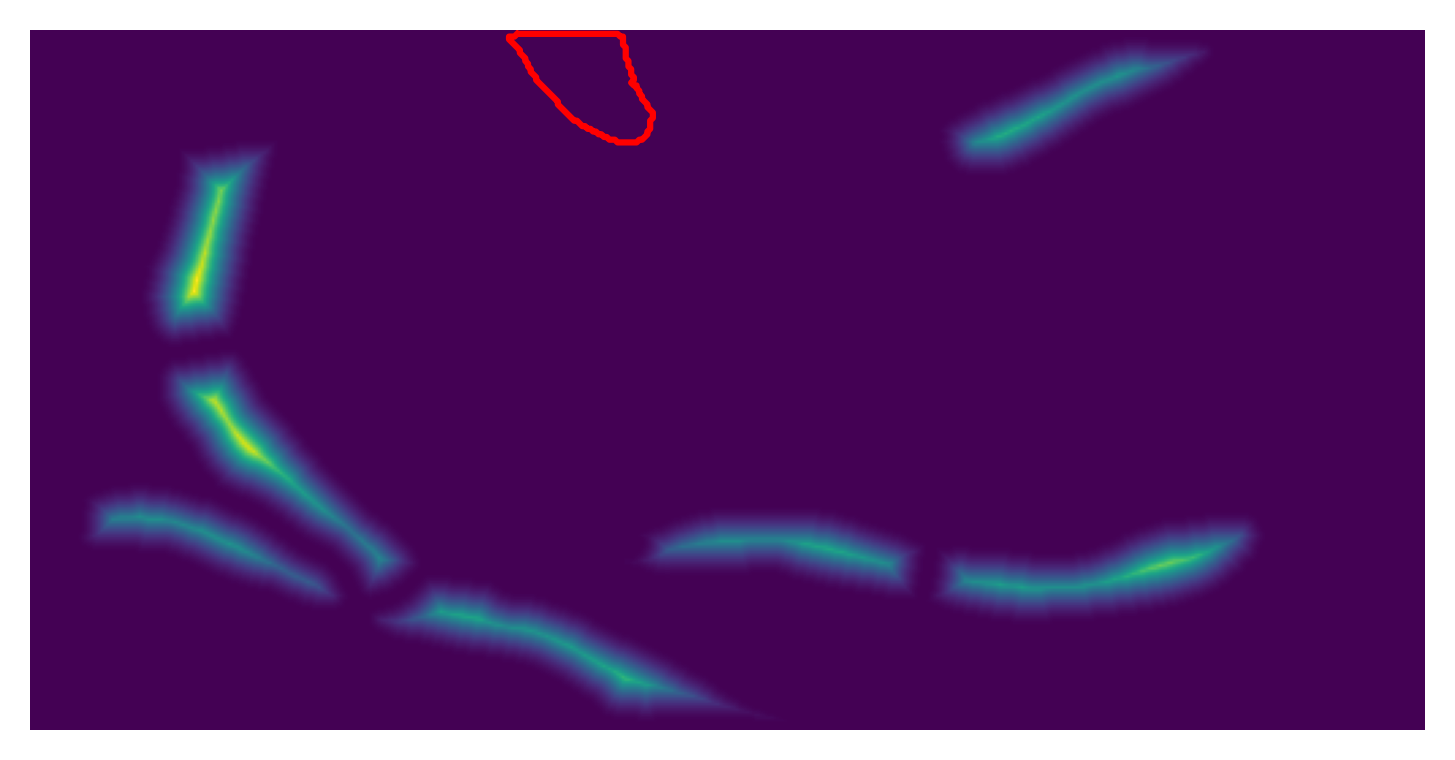

In [23]:
plt.imshow(utils.distance_to_boundary(dat['masks']))
# plot an individual cell of choice. 
plt.plot(outl[2][:,0], outl[2][:,1], color = "r")
plt.axis("off")
plt.savefig("test.png")

# Goals:
- Find center of all contours. Completed!!!
- Calculate if contours are touching each other and how much overlap there is. 
- Tell how distant the cell was from other contours in general? 
- Where was the cell in the overall image. 
- What was the time point of this image. Can calculate based on image name? 
- Use optical flow to track cell movement on a basic level. 
- Find a way to auto filter those weird looking cells. 
- What am I going to do when the pngs seem to change size randomly? Will any tracking I implement be able to cope? 
- How do I determine of cells are dividing vs being smushed together? Need the help of the actual data points? only bacteria connected pole to pole are touching? Take into account the time tracking? Maybe it should have an event for when a new cell appears. 

### determining overlap

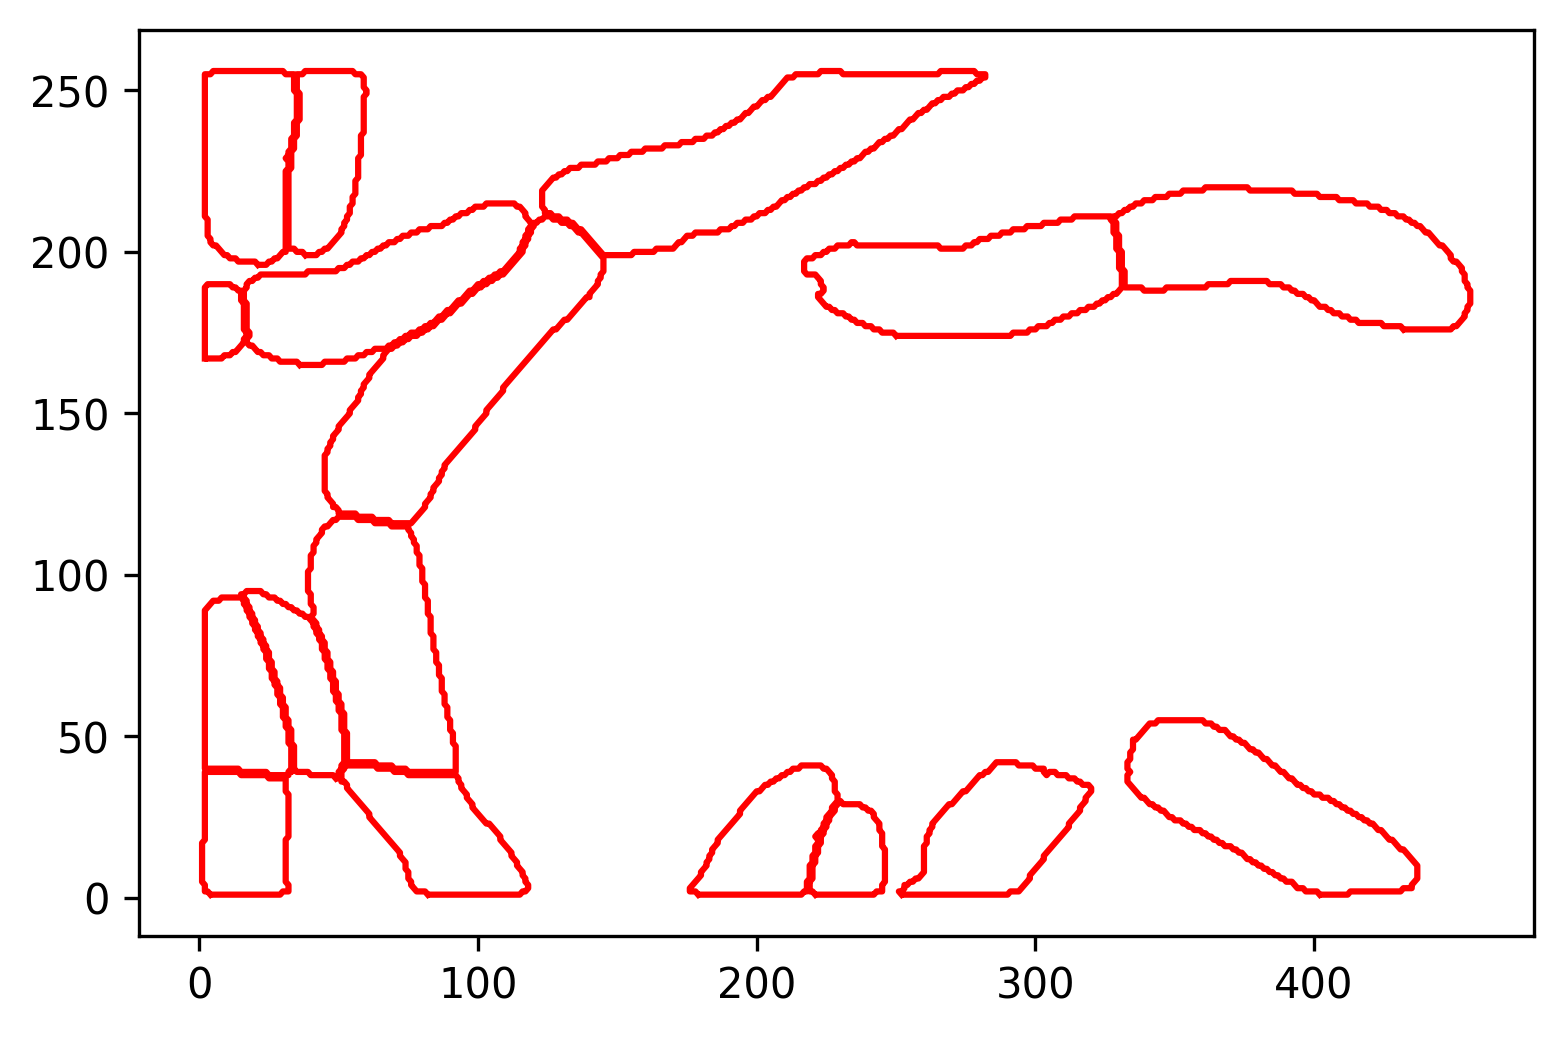

In [10]:
#plot just the outlines. 
outl = utils.outlines_list(dat['masks'])
for o in outl:
    plt.plot(o[:,0], o[:,1], color='r')


In [54]:
outl[2][:,0], outl[2][:,1]

(array([179, 178, 177, 176, 176, 177, 178, 179, 180, 180, 181, 182, 182,
        183, 183, 184, 184, 185, 186, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 227, 228, 228,
        228, 228, 229, 229, 229, 228, 227, 227, 226, 225, 225, 224, 224,
        223, 223, 222, 221, 222, 222, 221, 221, 221, 220, 220, 220, 219,
        219, 219, 219, 219, 218, 218, 218, 218, 217, 216, 215, 214, 213,
        212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 200,
        199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187,
        186, 185, 184, 183, 182, 181, 180]),
 array([ 1,  2,  2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 33, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 40, 4

In [55]:
outl[3][:,0], outl[3][:,1]

(array([221, 220, 219, 219, 219, 219, 220, 220, 220, 220, 220, 221, 221,
        221, 222, 222, 222, 223, 223, 223, 224, 224, 225, 225, 226, 226,
        227, 228, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 242, 243, 244, 244, 244, 245, 245, 245, 245,
        245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 245,
        245, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234,
        233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222]),
 array([ 1,  2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 29, 29, 29,
        29, 29, 29, 29, 28, 28, 27, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18,
        17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  2,
         2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1]))

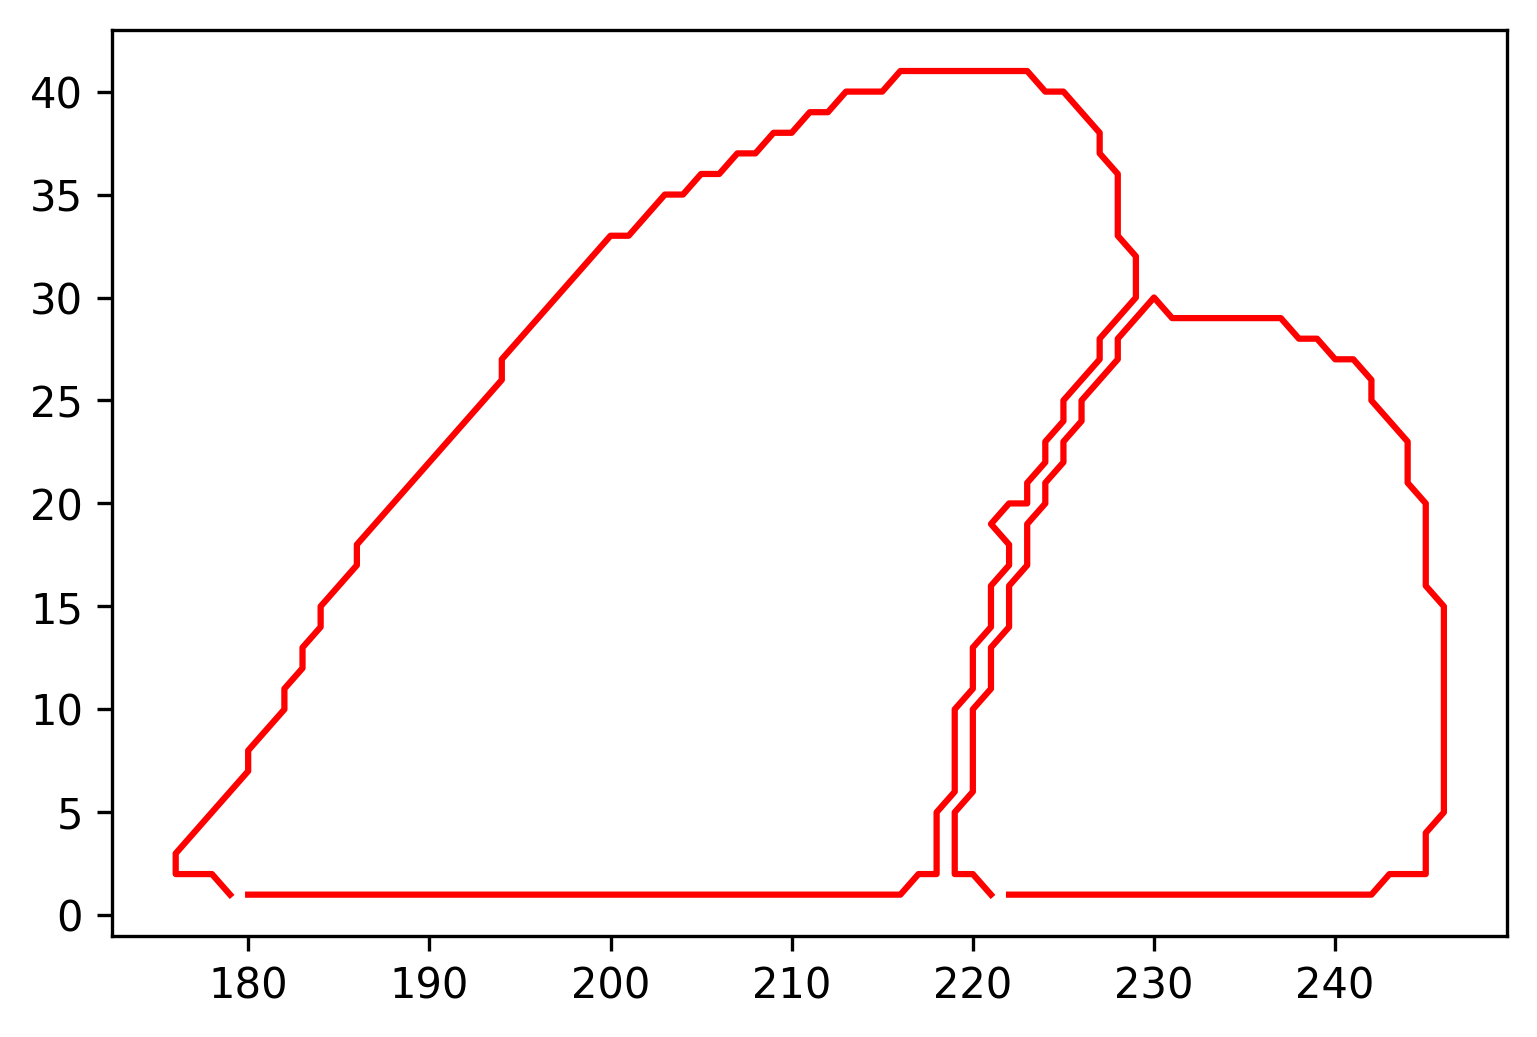

In [57]:
# plot an individual cell of choice. 
plt.plot(outl[3][:,0], outl[3][:,1], color = "r")
plt.plot(outl[2][:,0], outl[2][:,1], color = "r")
#plt.xlim((310,400))

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [75]:
adj = 0
for pixel1 in outl[3]:
    for pixel2 in outl[2]:
        distx = np.abs(pixel1[0]-pixel2[0])
        disty = np.abs(pixel1[1]-pixel2[1])
        if distx+disty == 1:
            adj = adj + 1

In [76]:
adj

39

In [ ]:
#OH SWEET GOD IN HEAVEN IT ACTUALLY KIND OF WORKED

for pixel in contour:
    for pixel2 in contour2:
        distx = np.abs(pixel[0]-pixel2[0])
        disty = np.abs(pixel[1]-pixel2[1])
        if distx+disty == 1:
            add one point to the overlap. 

And then I can add stuff together to get general distance as well? Honestly general distance can probably be solved with centroid measurements. 

Ok, so maybe I need to come at this on a pixel by pixel basis. Take each pixel, and have it scan all of the pixels that are 2 adjacent pixels away or more. If it finds even one that belongs to an different contour, then that pixel counts as a single "connected" pixel. this connectedness is added to a table with the metadata for each cell. Now how do I get it to ignore self pixels? 

Maybe an even better idea is to just measure closeness. Like, I take every pixel in a cell, and I measure its minimum distance to something else. If that minimum distance is 1 it is adjacent. If it is not 1 then they are not adjacent. 

Maybe simplify it all the way down to just finding adjacent pairs in the arrays? Like, it just looks through the arrays to find the nearly matching points? If I really do something like this, I would need somekind of filtering parameter, like only do this on cells that are at least this close based on a basic comparison on centroid distance. 